# Machine Vision
## Assignment 3 - Binary image analysis

## Personal details

* **Name(s):** `PUT YOUR NAME(S) HERE.`
* **Student ID(s):** `PUT YOUR STUDENT ID(S) HERE.`

## Introduction

In this assignment, you will implement a segmentation method to separate puzzle pieces from the background in an image of a jigsaw puzzle. The segmentation will use Otsu's method to automatically determine a threshold based on the grayscale histogram, dividing the image into dark and light regions. Once segmented, you will apply post-processing techniques to refine the binary image and improve the final result.

<img src="fig1.jpg">

Let us start by displaying the test image and the corresponding grayscale histogram.

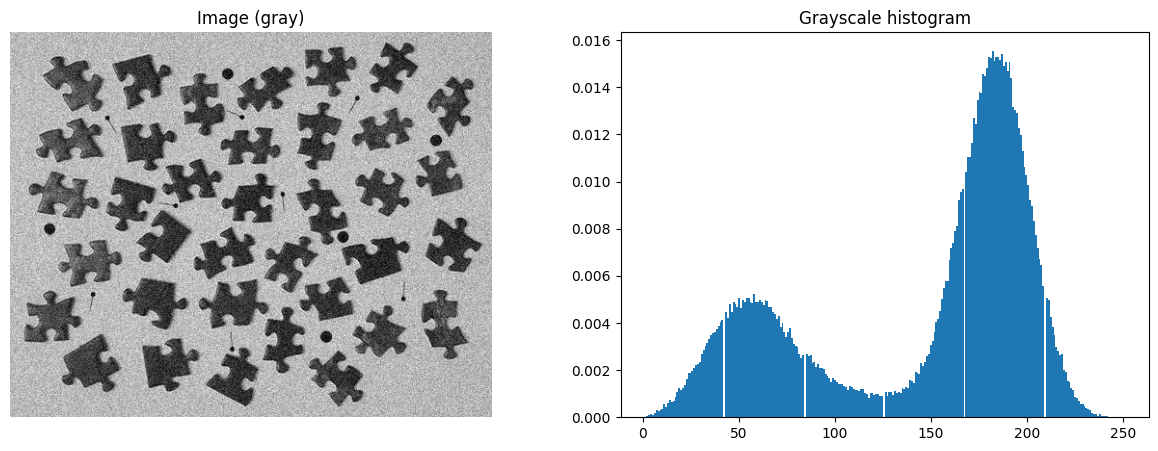

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('puzzle.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Image (gray)')
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title('Grayscale histogram')
h = plt.hist(gray.ravel(),256, density=True)

Notice that the image is quite noisy. This will make the segmentation more challenging. Before we continue with the segmentation, we want to reduce the noise. We will use the bilateral filter as it has the property of preserving edges and details.

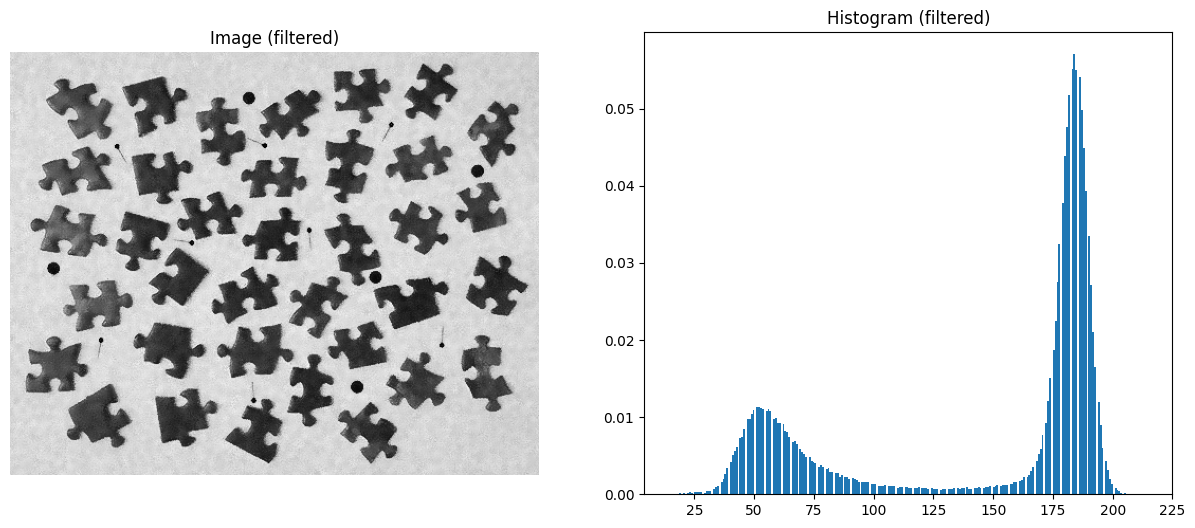

In [2]:
filt = cv2.bilateralFilter(gray,9,30,30)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Image (filtered)')
plt.imshow(filt, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title('Histogram (filtered)')
h2 = plt.hist(filt.ravel(),256, density=True)

## Manual segmentation

Now that we have filtered the image, we continue with the segmentation. A pixel should be classified as foreground if its intensity is less than a threshold value. We can see from the histogram that a good threshold value is somewhere between the peaks (in the valley). Let us pick a threshold $t=125$ and segment the image. We use the OpenCV function __[`threshold`](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#threshold)__.

(-0.5, 499.5, 399.5, -0.5)

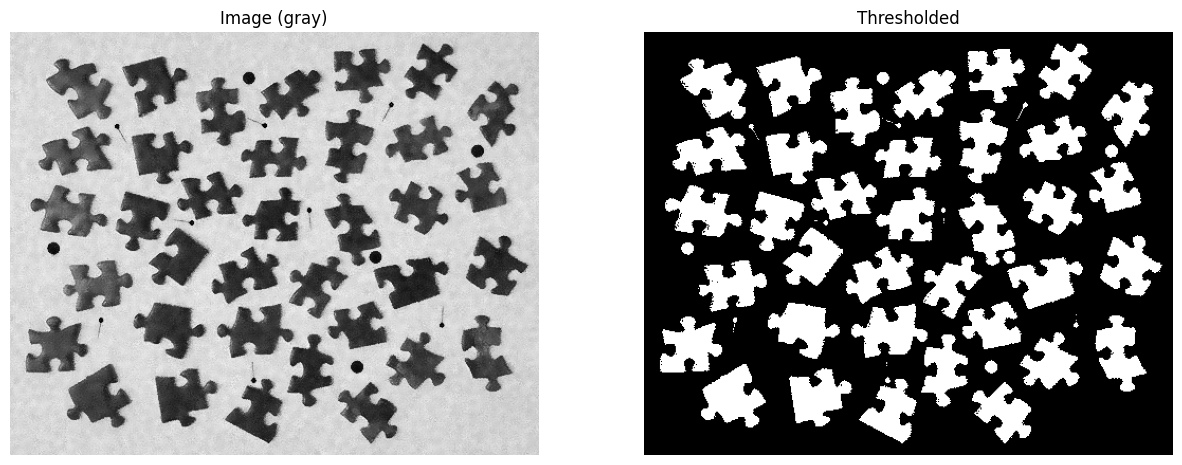

In [3]:
t = 125
ret,thresh = cv2.threshold(filt,t,255,cv2.THRESH_BINARY_INV)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(filt, cmap='gray')
plt.title('Image (gray)')
plt.axis('off')
plt.subplot(122)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded')
plt.axis('off')

## Task 1 - Otsu's method (2 points)

In the previous task, we chose the threshold manually. Otsu's method automates this process by looking at the histogram $P(i)$. It choses the threshold $t$ that minimizes the within-group variance defined as

$$
\sigma_w^2(t) = q_1(t) \sigma_1^2(t) + q_2(t) \sigma_2^2(t),\qquad (1)
$$

where $q_1(t)$ and $q_2(t)$ are the sums of histogram values

$$
q_1(t) = \sum_{i=0}^{t-1} P(i) \qquad q_2(t) = \sum_{i=t}^{I-1} P(i) \qquad (2)
$$

and $\sigma_1^2(t)$ and $\sigma_2^2(t)$ are variances

$$
\sigma_1^2(t) = \sum_{i=0}^{t-1} [i - \mu_1(t)]^2 \frac{P(i)}{q_1(t)}  \qquad \sigma_2^2(t) = \sum_{i=t}^{I-1} [i - \mu_2(t)]^2 \frac{P(i)}{q_2(t)}. \qquad (3)
$$

The mean values of the two distributions are

$$
\mu_1(t) = \sum_{i=0}^{t-1} \frac{i P(i)}{q_1(t)}  \qquad \mu_2(t) = \sum_{i=t}^{I-1} \frac{i P(i)}{q_2(t)}. \qquad (4)
$$

To implement Otsu's method, compute $\sigma_w^2(t)$ (Eq.1 ) for all possible threshold values $t$. After that, choose the threshold that gives the smallest within-group variance $\sigma_w^2(t)$.

### Instructions

Complete the function `computeGroupVariance` to calculate the within-group variance $\sigma_w^2(t)$ for a given threshold $t$.

1. Calculate $q_1(t)$ and $q_2(t)$ from the histogram $P(i)$ using Eq. 2.
2. Calculate $\mu_1(t)$, $\mu_2(t)$ (Eq. 4), and the variances $\sigma_1^2(t)$, $\sigma_2^2(t)$ (Eq. 3).
3. Return the within-group variance $\sigma_w^2(t)$ (Eq. 1).

**Tips!** Verify that your implementation works for all $t$ in the range $[0, 255]$. Add a small constant (e.g., $1 \times 10^{-9}$) to $q_1(t)$ and $q_2(t)$ to avoid division by zero. Test the function with $t = 125$. The expected results are $\sigma_w^2(t) \approx 176.7$, $\mu_1 \approx 63.3$, and $\mu_2 \approx 181.9$. Run the provided code to confirm your implementation.

In [6]:
# INPUTS
# P : Histogram probabilities (255x1 vector)
# t : Threshold value (scalar between [0,255])
#
# OUTPUT
# varw  : Within-group variance (scalar)
#
def computeGroupVariance(P, t):

    # The following line can be removed
    varw = 0

    # ---------- YOUR CODE STARTS HERE -----------

    # Compute q1 and q2 for a given threshold (Eq. 2)
    q1 = sum(P[0:t]) + 1e-9
    q2 = sum(P[t:]) + 1e-9

    # Compute mean values (Eq. 4)
    mean1 = sum((i * P[i])/ q1 for i in range(t))
    mean2 = sum((i * P[i])/ q2 for i in range(t, len(P) - 1))

    # Compute variances (Eq. 3)
    var1 = sum(((i - mean1)**2 * P[i])/ q1 for i in range(t))
    var2 = sum(((i - mean2)**2 * P[i])/ q2 for i in range(t, len(P) - 1))

    # Compute within-group variance (Eq. 1)
    varw = q1 * var1 + q2 * var2

    # ----------- YOUR CODE ENDS HERE ------------

    return varw


bins = np.arange(0,256,1)
P = np.histogram(filt.ravel(),bins,density=True)[0]

t = 125 # Threshold
varw = computeGroupVariance(P,t)
print("Within-group variance = %f (threshold %d)" %(varw,t))

Within-group variance = 176.726271 (threshold 125)


In [ ]:
# LEAVE EMPTY

### Segmentation

Next we are going to use the function to compute within-group variances for all thresholds. Then, we will choose the threshold that gives the smallest within-group variance. The threshold found using Otsu's method should be close to the threshold we picked manually.

Threshold = 123 (within-group variance 176.456421)


(-0.5, 499.5, 399.5, -0.5)

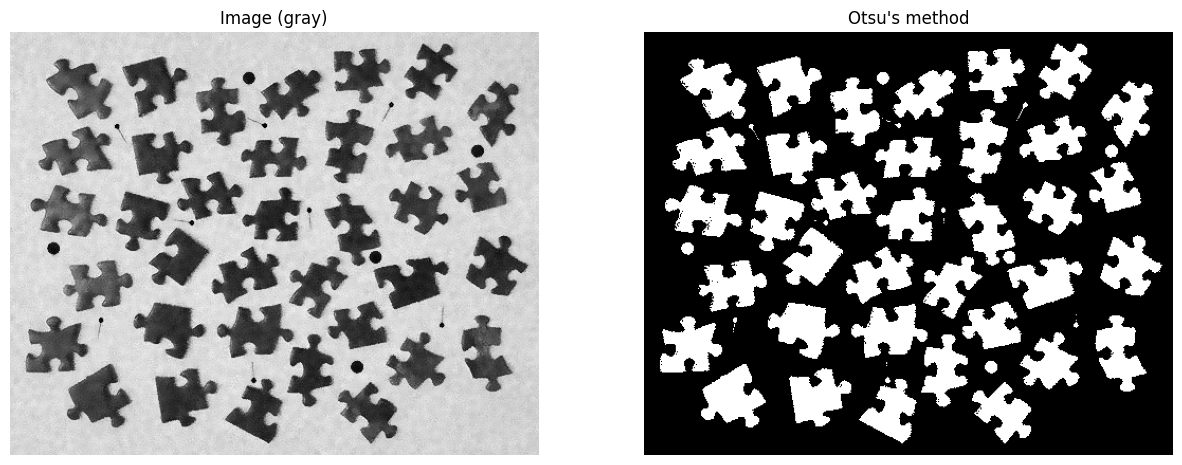

In [7]:
thresholds = np.arange(256)
varws = np.zeros(256, dtype=np.float32)

for idx, t in enumerate(thresholds):
    varw = computeGroupVariance(P,t)
    varws[idx] = varw

t = np.argmin(varws)
print("Threshold = %d (within-group variance %f)" %(t,varws[t]))

ret, otsu = cv2.threshold(filt,t,255,cv2.THRESH_BINARY_INV)
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(filt, cmap='gray')
plt.title('Image (gray)')
plt.axis('off')
plt.subplot(122)
plt.imshow(otsu, cmap='gray')
plt.title("Otsu's method")
plt.axis('off')

## Post-processing (optional)

The remaining steps of this notebook are optional and focus on refining the segmentation result. At this stage, the segmentation should be fairly accurate, but closer inspection reveals small holes, noise, and unwanted objects in the segmented image. To address these issues, we will refine the segmentation using morphological operations.

**Morphological operations**

The following code performs morphological closing to fill small holes in the segmented regions. This operation involves dilation followed by erosion and is effective in closing gaps within objects. Then, we will apply morphological opening to remove small noise and isolated regions. This operation consists of erosion followed by dilation.

While these steps improve the segmentation, some larger unwanted objects remain. These will be addressed in the following sections.

(-0.5, 499.5, 399.5, -0.5)

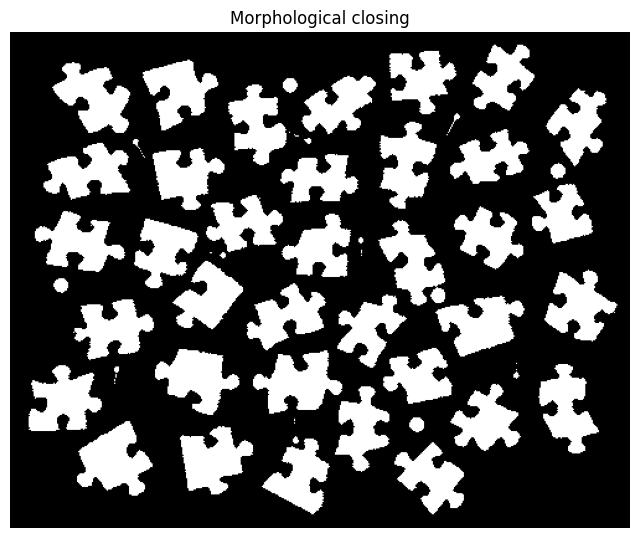

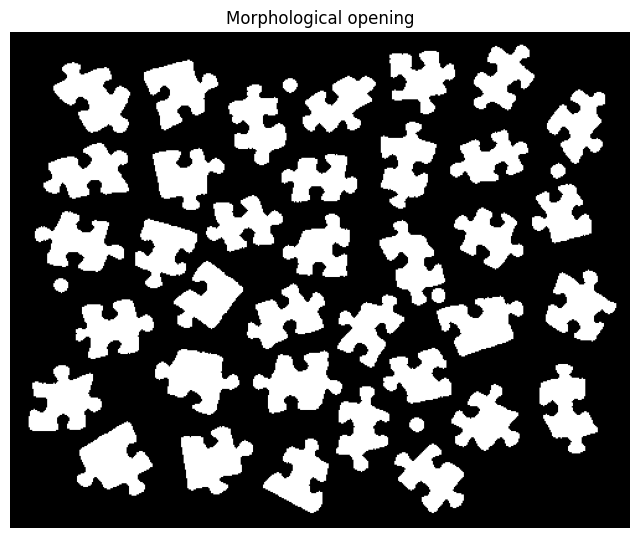

In [9]:
sel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
closing = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, sel1)

plt.figure(figsize=(8,8))
plt.imshow(closing, cmap='gray')
plt.title('Morphological closing')
plt.axis('off')

sel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, sel2)

plt.figure(figsize=(8,8))
plt.imshow(opening, cmap='gray')
plt.title('Morphological opening')
plt.axis('off')

**Connected component labeling**

The following code gives an unique label to each connected component in the binary image. It also extracts the contours of the objects. Notice that we still have more objects than we have puzzle pieces.

(-8.650000000000002, 511.65, 405.8, -7.800000000000001)

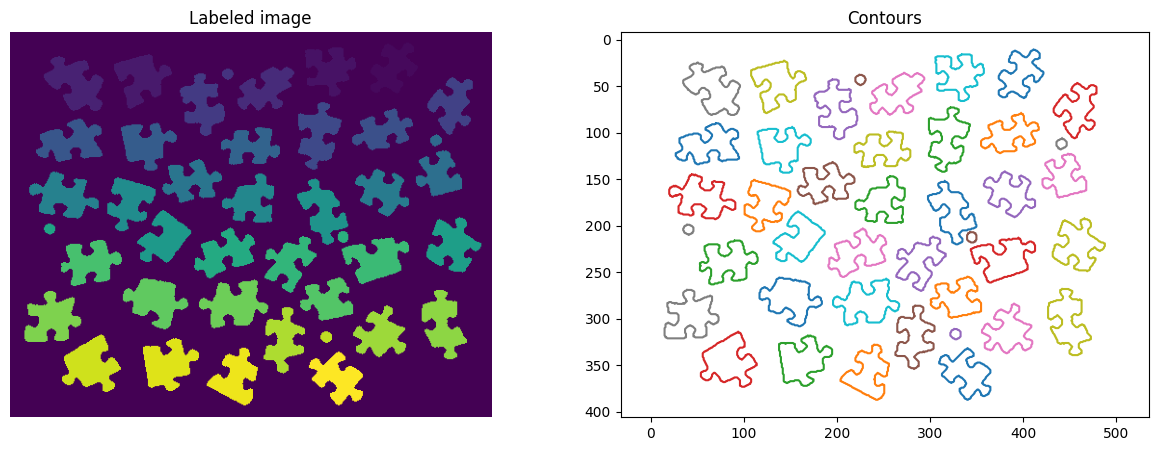

In [10]:
ret, labels = cv2.connectedComponents(opening)
cnt,_ = cv2.findContours(opening, 1, 1)
#_,cnt,_ = cv2.findContours(opening, 1, 1) # For older OpenCV versions

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(labels)
plt.title('Labeled image')
plt.axis('off')
plt.subplot(122)
for i in range(len(cnt)):
    plt.plot(cnt[i][:,0,0],cnt[i][:,0,1])
plt.gca().invert_yaxis()
plt.title('Contours')
plt.axis('equal')


**Removing small ojects**

As a final step, we remove those unwanted round objects. Luckily, they are much smaller than the puzzle pieces. We will compute the area of each contour using __[`contourArea`](https://docs.opencv.org/4.2.0/d3/dc0/group\_\_imgproc\_\_shape.html#ga2c759ed9f497d4a618048a2f56dc97f1)__ and keep objects, which area is more than 500. In the end, there are 36 objects in total (each jigsaw piece represents an object).

(-0.5, 499.5, 399.5, -0.5)

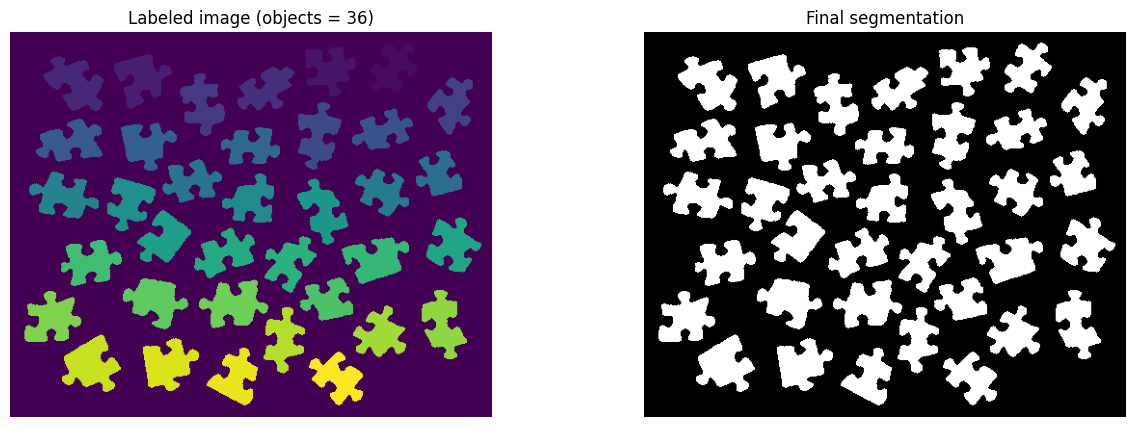

In [11]:
# This will be the final result (binary image)
final = np.zeros_like(otsu)

for i in range(len(cnt)):
    area = cv2.contourArea(cnt[i])
    if (area > 500):
        cv2.drawContours(final, cnt, i, 255, thickness=-1)

ret, labels_final = cv2.connectedComponents(final)
cnt_final,_ = cv2.findContours(final, 1, 1)
#_,cnt_final,_ = cv2.findContours(final, 1, 1) # For older OpenCV versions

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(labels_final)
plt.title('Labeled image')
plt.title("Labeled image (objects = %d)" %len(cnt_final))
plt.axis('off')
plt.subplot(122)
plt.imshow(final, cmap='gray')
plt.title('Final segmentation')
plt.axis('off')


**More advanced methods**

Our test image was relatively easy to segment. This was mainly because the background was much brighter compared to the puzzle pieces. If the background was different color, the segmentation might not work anymore. In such case, one could utilize some color-based segmentation method. If the puzzle pieces were touching each other, it would cause another challenge. We might be able to separate the pieces from the background but the individual pieces would be difficult to extract (connected component labeling) as the segmented regions might be overlapping. The __[`watershed`](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#watershed)__ algorithm is a classical method that is often used to segment overlapping objects. Furthermore, OpenCV also offers __[`grabCut`](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#grabcut)__ segmentation method, which is based on graph cuts.

# Aftermath

Please provide short answers to the following questions:

**1. How much time did you need to complete this exercise?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

**2. Did you experience any issues or find anything particularly confusing?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`


# References
`List any references here (optional).`

# Submission

1. Go to `Kernel -> Restart & Clear Output` to remove all outputs.
2. Compress this notebook (`MV_A3.ipynb`) into `MV_A3.zip`.
3. Submit the **zip** file on Moodle.

**Deadline: 2.2.2025**